In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
import imageio
import os
from os import path
import time
import math
import random
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Loading the dataset

In [57]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [58]:
len(X_train)

60000

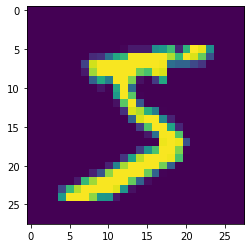

In [59]:
input = np.array(X_train[0])

plt.imshow(input)
plt.show()

In [60]:
# Parameters
image_train_time = 350

min_frequency = 1
max_frequency = 50

In [61]:
pixel_x = 28
T = 350

def rf(inp):
	sca1 =  0.625
	sca2 =  0.125
	sca3 = -0.125
	sca4 = -.5

	#Receptive field kernel
	w = [[	sca4 ,sca3 , sca2 ,sca3 ,sca4],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[ 	sca2 ,sca1 , 	1 ,sca1 ,sca2],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[	sca4 ,sca3 , sca2 ,sca3 ,sca4]]

	pot = np.zeros([pixel_x,pixel_x])
	ran = [-2,-1,0,1,2]
	ox = 2
	oy = 2

	#Convolution
	for i in range(pixel_x):
		for j in range(pixel_x):
			summ = 0
			for m in ran:
				for n in ran:
					if (i+m)>=0 and (i+m)<=pixel_x-1 and (j+n)>=0 and (j+n)<=pixel_x-1:
						summ = summ + w[ox+m][oy+n]*inp[i+m][j+n]/255
			pot[i][j] = summ
	return pot		




In [62]:

def encode(pot):

	#initializing spike train
	train = []

	for l in range(pixel_x):
		for m in range(pixel_x):
		
			temp = np.zeros([(T+1),])

			#calculating firing rate proportional to the membrane potential
			freq = np.interp(pot[l][m], [np.min(pot),np.max(pot)], [1,50])

				
			time_period = math.ceil(T/freq)

			#generating spikes according to the firing rate
			time_of_spike = time_period
			if(pot[l][m]>0):
				while time_of_spike<(T+1):
					temp[int(time_of_spike)] = 1
					time_of_spike+= time_period
			train.append(temp)
	return train


In [63]:
def encode_image_to_spike_train(image: np.ndarray):
    spike_trains = []

    for x_position in range(image.shape[0]):
        for y_position in range(image.shape[1]):

            pixel_value = image[x_position][y_position]

            spike_train = np.zeros(shape=(image_train_time+1,))

            # Transfer pixel value to set frequency range(and some other stuff, which interp does...)
            frequency = np.interp(pixel_value, [np.min(image),np.max(image)], [min_frequency,max_frequency])

            spike_time_distance = math.ceil(image_train_time / frequency)
            next_spike_time = spike_time_distance

            if pixel_value > 0:
                while next_spike_time < (image_train_time + 1):
                    # Add Spike to Spike Train
                    spike_train[int(next_spike_time)] = 1

                    # Calculate next spike
                    next_spike_time += spike_time_distance

            spike_trains.append(spike_train)

    return spike_trains


In [64]:
encode_image_to_spike_train(input)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [65]:
def receptive_field(image: np.ndarray):
    image_size_x = image.shape[0]
    image_size_y = image.shape[1]

    weight1 =  0.625
    weight2 =  0.125
    weight3 = -0.125
    weight4 = -.5

    # Receptive Field Kernel
    receptive_field = [
        [weight4 ,weight3 , weight2 ,weight3 ,weight4],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight2 ,weight1 ,   1     ,weight1 ,weight2],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight4 ,weight3 , weight2 ,weight3 ,weight4]]

    convoluted_image = np.zeros(shape=image.shape)

    window = [-2,-1,0,1,2]
    x_offset = 2
    y_offset = 2

    # Apply Convolution with Receptive Field Kernel
    for x_image_index in range(image_size_x):
        for y_image_index in range(image_size_y):
            summation = 0
            for x_kernel_index in window:
                for y_kernel_index in window:
                    if (x_image_index+x_kernel_index)>=0 and (x_image_index+x_kernel_index)<=image_size_x-1 and (y_image_index+y_kernel_index)>=0 and (y_image_index+y_kernel_index)<=image_size_y-1:
                        summation = summation + (receptive_field[x_offset+x_kernel_index][y_offset+y_kernel_index] * image[x_image_index+x_kernel_index][y_image_index+y_kernel_index]) / 255
            convoluted_image[x_image_index][y_image_index] = summation
    return convoluted_image


In [66]:
print((rf(input) == receptive_field(input)).all())
#print((encode(input) == encode_image_to_spike_train(input)).all())

np.array_equal(encode(rf(input)),encode_image_to_spike_train(rf(input))) 

True


True

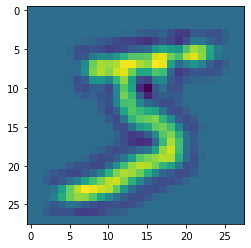

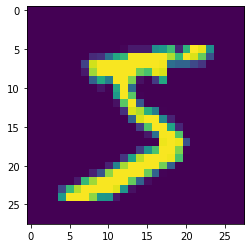

In [67]:
receptive_field_output = receptive_field(input)

plt.imshow(receptive_field_output)
plt.show()
plt.imshow(input)
plt.show()

In [68]:
# Simulation Parameters
image_train_time = 350 #Training time for every image
past_window = -5
# epochs = 1

# Input Parameters
training_set_path= "./MNIST/training/"
image_size = (28,28)
resting_potential = -70
layer1_size = image_size[0] * image_size[1] # Number of neurons in first layer
# layer2_size =  800  # Number of neurons in second layer

# Neuron Parameters
inhibitory_potential = -100
spike_threshold = -55
hyperpolarization_potential = -90
# spike_drop_rate = 0.8
# threshold_drop_rate = 0.4
min_weight = 0.00001
max_weight = 1.0

# STDP Parameters
STDP_offset = 0
sigma = 0.01
A_plus = 0.8
A_minus = 0.8
tau_plus = 5
tau_minus = 5
mu=0.9

In [69]:
class Neuron:
	def hyperpolarization(self, time_step):
		self.potential = hyperpolarization_potential
		self.rest_until = time_step + self.refractory_period

	def inhibit(self, time_step):
		self.potential = inhibitory_potential
		self.rest_until = time_step + self.refractory_period

	def initial(self):
		self.adaptive_spike_threshold = spike_threshold
		self.rest_until = -1
		self.refractory_period = 15 #(us)
		self.potential = resting_potential

In [70]:
# STDP reinforcement learning curve
def STDP_weighting_curve(time_step: int):
	if time_step>0:
		return -A_plus*(np.exp(-float(time_step)/tau_plus)-STDP_offset)
	if time_step<=0:
		return A_minus*(np.exp(float(time_step)/tau_minus)-STDP_offset)


# STDP weight update rule
def update_synapse(synapse_weight, weight_factor):
	if weight_factor<0:
		return synapse_weight + sigma * weight_factor * (synapse_weight - abs(min_weight))**mu
	elif weight_factor>0:
		return synapse_weight + sigma * weight_factor * (max_weight - synapse_weight)**mu

In [71]:
def visualize_weights(weights, num):
	weights = np.array(weights)
	weights = np.reshape(weights, image_size)
	img = np.zeros(image_size)
	for x_coordinate in range(image_size[0]):
		for y_coordinate in range(image_size[1]):
			img[x_coordinate][y_coordinate] = int(np.interp(weights[x_coordinate][y_coordinate], [min_weight, max_weight], [0,255]))

	imageio.imwrite('Neurons/neuron_' + str(num) + '.png' ,img.astype(np.uint8))
	return img

In [72]:
def train(spike_drop_rate=0.8, threshold_drop_rate=0.4, layer2_size=800, epochs=1):    
    potentials = []
    potential_thresholds = []
    for image_path in range(layer2_size):
        potentials.append([])
        potential_thresholds.append([])

    time_of_learning = np.arange(1, image_train_time + 1, 1)

    output_layer = []

    # Creating Second Layer
    for image_path in range(layer2_size):
        neuron = Neuron()
        neuron.initial() # TODO In die __init__()
        output_layer.append(neuron)

    # Random synapse matrix	initialization
    synapses = np.random.uniform(low=0.95, high=1.0, size=(layer2_size , layer1_size)) # np.ones((layer2_size , layer1_size)) 
    max_weight = np.max(synapses)
    synapse_memory = np.zeros((layer2_size ,layer1_size))

    # Creating labels corresponding to neuron
    label_neuron = np.repeat(-1 , layer2_size)

    for epoch in range(epochs):
        for folder in os.listdir('./MNIST/training/'):
            for image_path in os.listdir("./MNIST/training/" + folder + "/")[:80]:
                time_start = time.time()

                img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)

                # Convolving image with receptive field and encoding to generate spike train
                spike_train = np.array(encode_image_to_spike_train(receptive_field(img)))

                # Local variables
                winner_index = None
                count_spikes = np.zeros(layer2_size)
                current_potentials = np.zeros(layer2_size)

                # Leaky integrate and fire neuron dynamics
                for time_step in time_of_learning:

                    for neuron_index, neuron in enumerate(output_layer):
                        if(neuron.rest_until < time_step):
                            # Increase potential according to the sum of synapses inputs
                            neuron.potential += np.dot(synapses[neuron_index], spike_train[: , time_step])

                            if(neuron.potential > resting_potential):
                                neuron.potential -= spike_drop_rate

                                if(neuron.adaptive_spike_threshold > spike_threshold):
                                        neuron.adaptive_spike_threshold -= threshold_drop_rate
                                        
                            current_potentials[neuron_index] = neuron.potential

                        potentials[neuron_index].append(neuron.potential) # Only for plotting: Changing potential overtime
                        potential_thresholds[neuron_index].append(neuron.adaptive_spike_threshold) # Only for plotting: Changing threshold overtime

                    winner_index = np.argmax(current_potentials)
                    winner_neuron = output_layer[winner_index]

                    # Check for spikes and update weights
                    if current_potentials[winner_index] > winner_neuron.adaptive_spike_threshold:
                        count_spikes[winner_index] += 1

                        winner_neuron.hyperpolarization(time_step)
                        winner_neuron.adaptive_spike_threshold += 1 # Adaptive Membrane/Homoeostasis: Increasing the threshold of the neuron

                        for layer1_index in range(layer1_size):
                            for past_time_step in range(0, past_window-1, -1): # if presynaptic spike came before postsynaptic spike
                                if 0 <= time_step + past_time_step < image_train_time + 1:
                                    if spike_train[layer1_index][time_step + past_time_step] == 1:  # if presynaptic spike was in the tolerance window
                                        synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(past_time_step))  # strengthen weights
                                        synapse_memory[winner_index][layer1_index] = 1 # TODO Possible Reset necessary - somewhere?!?!?
                                        break
                            if synapse_memory[winner_index][layer1_index] != 1:  # if presynaptic spike was not in the tolerance window, reduce weights of that synapse
                                synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(1))

                        # Inhibit all LOOSERS
                        for looser_neuron_index, looser_neuron in enumerate(output_layer):
                            if looser_neuron_index != winner_index:
                                if (looser_neuron.potential > looser_neuron.adaptive_spike_threshold):
                                    count_spikes[looser_neuron_index] += 1

                                looser_neuron.inhibit(time_step) # TODO So nothing happens for a few time steps afterwards?!?!?!?

                # bring neuron potentials to rest
                for neuron_index, neuron in enumerate(output_layer):
                    neuron.initial()

                label_neuron[winner_index] = int(folder)

                # print("Image: " + i + " Spike Count = ", count_spikes)
                print("Learning Neuron: ", np.argmax(count_spikes))
                print("Learning duration: ", time.time() - time_start)
                # to write intermediate synapses for neurons
                # for p in range(layer2_size):
                #		reconst_weights(synapse[p],str(p)+"_epoch_"+str(k))

    """ print(count_spikes)
    # Plotting
    ttt = np.arange(0,len(potentials[0]),1)
    for i in range(layer2_size):
        axes = plt.gca()
        plt.plot(ttt, potential_thresholds[i], 'r' )
        plt.plot(ttt, potentials[i])
        plt.show() """

    if not path.exists("Neurons"):
        os.mkdir("Neurons")

    if not path.exists("visualized_weights"):
        os.mkdir("visualized_weights")

    # Reconstructing weights to analyze training
    for layer2_index in range(layer2_size):
        if label_neuron[layer2_index] == -1:
            for layer1_index in range(layer1_size):
                synapses[layer2_index][layer1_index] = 0
        visualize_weights(synapses[layer2_index], str(layer2_index) + "_final")
    np.savetxt("visualized_weights/weights.csv", synapses, delimiter=",")
    np.savetxt("visualized_weights/labels.csv", label_neuron, delimiter=',')


In [73]:
def test(layer1_size, layer2_size=800):	
	#time series 
	time_of_learning = np.arange(1, image_train_time+1, 1)
	output_layer = []
	# creating the hidden layer of neurons

	#synapse matrix
	synapses = np.zeros((layer2_size,layer1_size))
	#learned weights
	learned_weights=pd.read_csv("weights.csv",header=None)
	neuron_labels=pd.read_csv("labels.csv",header=None)
	labels_matrix=np.array(neuron_labels.values)
	weight_matrix = np.array(learned_weights.values)

	layer1_size = weight_matrix.shape[1] # Number of neurons in first layer
	layer2_size = weight_matrix.shape[0] # Number of neurons in second layer

	for layer2_index in range(layer2_size):
		neuron = Neuron() # TODO Why no initial method?
		output_layer.append(neuron)
		synapses[layer2_index] = weight_matrix[layer2_index]


	predicted_class=[]
	actual_class=[]
	prediction_count=np.zeros((layer2_size,layer2_size))
	for folder in range(10):
		images_path='./MNIST/testing/' + str(folder) + '/'
		
		for image_name in os.listdir(images_path)[:10]:
			time_start = time.time()
			
			count_spikes = np.zeros((layer2_size,1))

			#read the image to be classified
			image = imageio.imread(images_path + image_name)

			#initialize the potentials of output neurons
			for neuron in output_layer:
				neuron.initial()

			#generate spike trains. Select between deterministic and stochastic
			spike_train = np.array(encode_image_to_spike_train(receptive_field(image)))

			#flag for lateral inhibition
			f_spike = 0 # TODO Do we need this?
			current_potentials = np.zeros((layer2_size,1))
			winner_index = None
			for time_step in time_of_learning:
					for layer2_index, neuron in enumerate(output_layer):

						if(neuron.rest_until < time_step):
							neuron.potential = neuron.potential + np.dot(synapses[layer2_index], spike_train[:,time_step])

							if(neuron.potential>resting_potential):
								neuron.potential -= spike_drop_rate
								
						current_potentials[layer2_index] = neuron.potential

					winner_index = np.argmax(current_potentials)

					for layer2_index, neuron in enumerate(output_layer):
						if(layer2_index == winner_index):
							if(current_potentials[layer2_index] > neuron.adaptive_spike_threshold):
								count_spikes[layer2_index] += 1
								neuron.adaptive_spike_threshold += 1 # TODO += 1??
								neuron.hyperpolarization(time_step)

								for looser_neuron_index, looser_neuron in enumerate(output_layer):
									if looser_neuron_index != winner_index:
										if(looser_neuron.potential>looser_neuron.adaptive_spike_threshold):
											looser_neuron.inhibit(time_step)
								break
			
			#print(count_spikes)
			print(image_name)
			print("Predicted_class = ",labels_matrix[np.argmax(count_spikes)][0])
			print("Actual class = ",folder)
			print("Time for inference = ",time.time()-time_start)
			predicted_class.append(labels_matrix[np.argmax(count_spikes)][0])
			actual_class.append(folder)
			prediction_count[int(folder)][int(labels_matrix[np.argmax(count_spikes)][0])]+=1
			#print("Prediction for "+str(folder_number)+" : ",prediction_count[folder_number])
	accuracy=(np.sum(np.array(predicted_class)==np.array(actual_class))/len(predicted_class))*100
	np.savetxt("prediction_matrix.csv",prediction_count,delimiter=',')
	print(accuracy)

In [74]:
train()
test(layer1_size)

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\1233560472.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)


Learning Neuron:  55
Learning duration:  2.3626532554626465
Learning Neuron:  94
Learning duration:  2.4042110443115234
Learning Neuron:  293
Learning duration:  2.68345308303833
Learning Neuron:  514
Learning duration:  2.4332163333892822
Learning Neuron:  376
Learning duration:  2.171987533569336
Learning Neuron:  92
Learning duration:  2.8766191005706787
Learning Neuron:  579
Learning duration:  2.3971970081329346
Learning Neuron:  293
Learning duration:  2.631399154663086
Learning Neuron:  92
Learning duration:  2.4112062454223633
Learning Neuron:  92
Learning duration:  2.1625301837921143
Learning Neuron:  161
Learning duration:  2.5533101558685303
Learning Neuron:  92
Learning duration:  2.4952945709228516
Learning Neuron:  604
Learning duration:  2.409203052520752
Learning Neuron:  92
Learning duration:  1.8026599884033203
Learning Neuron:  741
Learning duration:  2.2461652755737305
Learning Neuron:  92
Learning duration:  2.5343170166015625
Learning Neuron:  454
Learning durati

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\3299192333.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + image_name)


10.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7897284030914307
1001.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7240147590637207
1009.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7496926784515381
101.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7917308807373047
1034.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7747156620025635
1047.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7737143039703369
1061.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7416839599609375
1084.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7306735515594482
1094.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.709653377532959
1121.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7046515941619873
1004.png
Predicted_class =  1.0
Actual class =  1
Time for inference =  0.9423868656158447
100

In [75]:
train(epochs=2)
test(layer1_size)

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\1233560472.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)


Learning Neuron:  165
Learning duration:  2.397191286087036
Learning Neuron:  151
Learning duration:  2.3843367099761963
Learning Neuron:  522
Learning duration:  2.6664376258850098
Learning Neuron:  182
Learning duration:  2.3896472454071045
Learning Neuron:  11
Learning duration:  2.052900791168213
Learning Neuron:  380
Learning duration:  2.8832547664642334
Learning Neuron:  779
Learning duration:  2.5783653259277344
Learning Neuron:  522
Learning duration:  2.6179542541503906
Learning Neuron:  380
Learning duration:  2.604933738708496
Learning Neuron:  380
Learning duration:  2.137519121170044
Learning Neuron:  457
Learning duration:  2.2270560264587402
Learning Neuron:  380
Learning duration:  2.497828960418701
Learning Neuron:  623
Learning duration:  2.3841805458068848
Learning Neuron:  380
Learning duration:  1.8066396713256836
Learning Neuron:  662
Learning duration:  2.2530744075775146
Learning Neuron:  380
Learning duration:  2.549320936203003
Learning Neuron:  602
Learning 

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\3299192333.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + image_name)


10.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7747132778167725
1001.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7196741104125977
1009.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7507023811340332
101.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7837224006652832
1034.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.771714448928833
1047.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7672312259674072
1061.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7346813678741455
1084.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.726661205291748
1094.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7144956588745117
1121.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.6957080364227295
1004.png
Predicted_class =  1.0
Actual class =  1
Time for inference =  0.9398651123046875
1008

In [76]:
train(spike_drop_rate=0.7, threshold_drop_rate=0.3)
test(layer1_size)

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\1233560472.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)


Learning Neuron:  704
Learning duration:  2.263576030731201
Learning Neuron:  596
Learning duration:  2.1459646224975586
Learning Neuron:  162
Learning duration:  2.684455156326294
Learning Neuron:  21
Learning duration:  2.61930513381958
Learning Neuron:  380
Learning duration:  2.125936269760132
Learning Neuron:  408
Learning duration:  2.8761231899261475
Learning Neuron:  436
Learning duration:  2.3541553020477295
Learning Neuron:  162
Learning duration:  2.4162371158599854
Learning Neuron:  408
Learning duration:  2.3891847133636475
Learning Neuron:  408
Learning duration:  2.291616439819336
Learning Neuron:  167
Learning duration:  2.3651556968688965
Learning Neuron:  408
Learning duration:  2.756512403488159
Learning Neuron:  401
Learning duration:  2.330134391784668
Learning Neuron:  408
Learning duration:  2.0298690795898438
Learning Neuron:  799
Learning duration:  2.4001858234405518
Learning Neuron:  408
Learning duration:  2.4992759227752686
Learning Neuron:  711
Learning du

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\3299192333.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + image_name)


10.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7757062911987305
1001.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7226579189300537
1009.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7717030048370361
101.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7917211055755615
1034.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7636947631835938
1047.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7626943588256836
1061.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7316691875457764
1084.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7306649684906006
1094.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7186543941497803
1121.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7076442241668701
1004.png
Predicted_class =  1.0
Actual class =  1
Time for inference =  0.9358522891998291
10

In [77]:
train(spike_drop_rate=0.6, threshold_drop_rate=0.2)
test(layer1_size)

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\1233560472.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)


Learning Neuron:  750
Learning duration:  1.9618113040924072
Learning Neuron:  352
Learning duration:  2.061335325241089
Learning Neuron:  21
Learning duration:  2.715472459793091
Learning Neuron:  592
Learning duration:  2.652453660964966
Learning Neuron:  385
Learning duration:  2.0649032592773438
Learning Neuron:  307
Learning duration:  3.032996892929077
Learning Neuron:  180
Learning duration:  2.5263001918792725
Learning Neuron:  307
Learning duration:  2.6774380207061768
Learning Neuron:  307
Learning duration:  2.280075788497925
Learning Neuron:  307
Learning duration:  2.5823614597320557
Learning Neuron:  588
Learning duration:  2.3931801319122314
Learning Neuron:  307
Learning duration:  2.8796205520629883
Learning Neuron:  585
Learning duration:  1.9958202838897705
Learning Neuron:  307
Learning duration:  1.9537861347198486
Learning Neuron:  498
Learning duration:  2.4151999950408936
Learning Neuron:  307
Learning duration:  1.9918129444122314
Learning Neuron:  510
Learning

C:\Users\wolff\AppData\Local\Temp\ipykernel_12260\3299192333.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(images_path + image_name)


10.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7838902473449707
1001.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7280590534210205
1009.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7595095634460449
101.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7967360019683838
1034.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7807111740112305
1047.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7707183361053467
1061.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7396900653839111
1084.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7298891544342041
1094.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7170188426971436
1121.png
Predicted_class =  0.0
Actual class =  0
Time for inference =  0.7096548080444336
1004.png
Predicted_class =  1.0
Actual class =  1
Time for inference =  0.9398558139801025
10